In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install matplotlib numpy scikit-learn

Episode 1, Total Reward: -50.0
Episode 2, Total Reward: -52.0
Episode 3, Total Reward: 36.0
Episode 4, Total Reward: -8.0
Episode 5, Total Reward: -38.0
Episode 6, Total Reward: 14.0
Episode 7, Total Reward: 28.0
Episode 8, Total Reward: -4.0
Episode 9, Total Reward: 28.0
Episode 10, Total Reward: 84.0


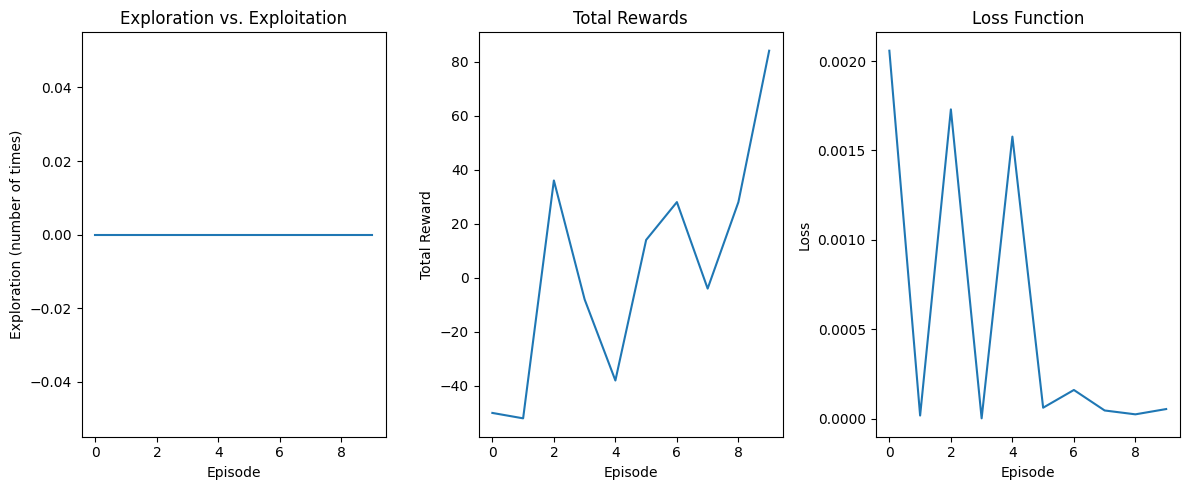

Test Accuracy: 15.55
Confusion Matrix:
[[151  45]
 [147  57]]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import random
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# CNN model for feature extraction
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
        nn.Conv2d(3, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Linear(16 * 111 * 111, 64)

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 111 * 111)
        x = torch.relu(self.fc(x))
        return x
# data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = '/content/drive/MyDrive/Processed_Images (1)/Binary'
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# DQN model for reinforcement learning
class DQNModel(nn.Module):
    def __init__(self, num_actions):
        super(DQNModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_actions)
        )

    def forward(self, x):
        return self.fc(x)

class DQNAgent:
    def __init__(self, model, num_actions):
        self.model = model
        self.num_actions = num_actions

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randrange(self.num_actions)  # Explore
        else:
            with torch.no_grad():
                q_values = self.model(state)
                action = torch.argmax(q_values, dim=1).item()  # Exploit
                return action

# Creating a DQN model
cnn_model = CNNModel()
num_actions = 2  # Two actions: 'normal' and 'COVID-19'
dqn_model = DQNModel(num_actions)

# DQN agent
dqn_agent = DQNAgent(dqn_model, num_actions)

class BinaryClassificationEnvironment:
    def __init__(self, cnn_model, dataset):
        self.cnn_model = cnn_model
        self.dataset = dataset
        self.current_index = 0

    def reset(self):
        self.current_index = 0
        first_image, first_label = self.dataset[self.current_index]
        self.current_index += 1
        initial_state = cnn_model(first_image)
        return initial_state

    def step(self, state, action):
        if self.current_index < len(self.dataset) - 1:
            next_image, next_label = self.dataset[self.current_index]
            self.current_index += 1
            next_state = cnn_model(next_image)
            reward = 1.0 if action == next_label else -1.0
            done = False

        else:
            next_state = state
            reward = 0.0
            done = True

        return next_state, reward, done

env = BinaryClassificationEnvironment(cnn_model, train_data)

# Define RL training parameters and optimizer
learning_rate = 0.001
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.995  # Decay rate for epsilon
min_epsilon = 0.1  # Minimum exploration rate

target_dqn_model = DQNModel(num_actions)  # Target network for stability
target_dqn_model.load_state_dict(dqn_model.state_dict())
target_dqn_model.eval()
optimizer = optim.Adam(dqn_model.parameters(), lr=learning_rate)

# Training loop
initial_epsilon = 1.0
num_episodes = 10
exploration_vs_exploitation = []
total_rewards = []
losses = []
for episode in range(num_episodes):
    epsilon = max(min_epsilon, initial_epsilon * epsilon_decay**episode)
    total_reward = 0.0
    done = False
    state = env.reset()
    episode_exploration = 0

    while not done:
        action = dqn_agent.select_action(state, epsilon)
        next_state, reward, done = env.step(state, action)

        #epsilon = max(epsilon * epsilon_decay, min_epsilon)

        # Update target network
        target_dqn_model.load_state_dict(dqn_model.state_dict())

        q_values = dqn_model(state)
        q_value = q_values[0][action]

        q_values = dqn_model(state)
        q_value = q_values[0][action]

        next_q_values = dqn_model(next_state)
        max_next_q_value = torch.max(next_q_values)

        target_q_value = reward + gamma * max_next_q_value
        loss = nn.MSELoss()(q_value, target_q_value)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        total_reward += reward
        state = next_state

    #exploration_vs_exploitation.append(episode_exploration)
    total_rewards.append(total_reward)
    losses.append(loss.item())
    print(f'Episode {episode + 1}, Total Reward: {total_reward}')


# Plot total rewards curve
plt.subplot(132)
plt.plot(total_rewards)
plt.title('Total Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# Plot loss function curve
plt.subplot(133)
plt.plot(losses)
plt.title('Loss Function')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Evaluation on test data
dqn_model.eval()
test_rewards = []
true_labels = []
predicted_labels = []

for data, target in test_loader:
    with torch.no_grad():
        output = dqn_model(cnn_model(data))
    predicted = output.max(1, keepdim=True)[1]
    test_rewards.append((predicted == target).sum().item())
    true_labels.extend(target.tolist())
    predicted_labels.extend(predicted.tolist())

accuracy = sum(test_rewards) / len(test_data)
confusion = confusion_matrix(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print(f'Test Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Test Accuracy: 15.55


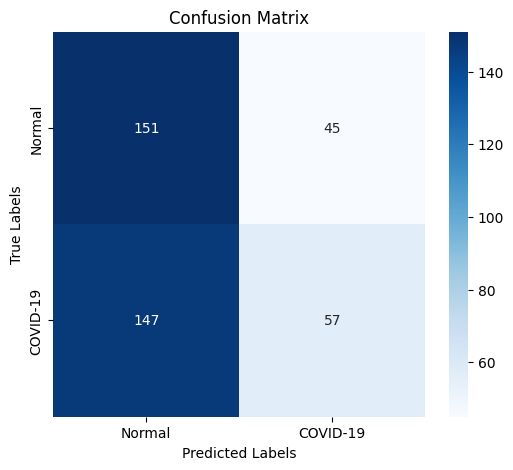

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import random
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation on test data
dqn_model.eval()
test_rewards = []
true_labels = []
predicted_labels = []

for data, target in test_loader:
    with torch.no_grad():
        output = dqn_model(cnn_model(data))
    predicted = output.max(1, keepdim=True)[1]
    test_rewards.append((predicted == target).sum().item())
    true_labels.extend(target.tolist())
    predicted_labels.extend(predicted.tolist())

accuracy = sum(test_rewards) / len(test_data)
confusion = confusion_matrix(true_labels, predicted_labels)
print(f'Test Accuracy: {accuracy}')

plt.figure(figsize=(6, 5))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'COVID-19'], yticklabels=['Normal', 'COVID-19'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

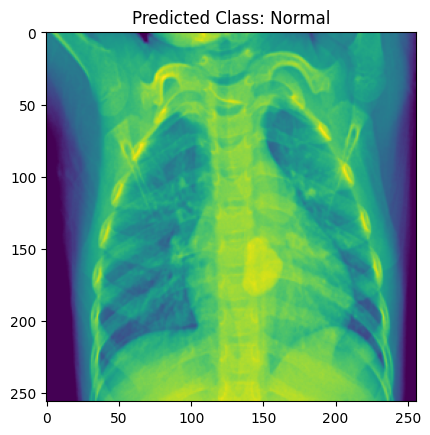

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/drive/MyDrive/Processed_Images (1)/Binary/Normal_patient (1)/Normal-95_output (1).png'  # Change this to the path of your input image
input_image = Image.open(image_path)

#input_image = input_image.convert('L')

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

# Set your DQN model to evaluation mode
dqn_model.eval()

# Use your model to make predictions
with torch.no_grad():
    cnn_output = cnn_model(input_batch)
    dqn_output = dqn_model(cnn_output)

# Get the predicted class
predicted_class = torch.argmax(dqn_output, dim=1).item()
class_names = ['Normal', 'COVID-19']  # Modify this list based on your class labels

# Display the input image and the predicted class
plt.imshow(input_image)
plt.title(f'Predicted Class: {class_names[predicted_class]}')
plt.show()